```sh
conda create -n stardist python=3.8
conda activate stardist
pip install tensorflow-gpu==2.11.0
pip install stardist==0.9.1

# If want to use GPU.
pip install gputools
```

**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
IMG_PATH = '../../datasets/neun'

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

2024-09-04 22:38:15.669460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 22:38:18.137728: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 22:38:18.522314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-04 22:38:18.522358: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [14]:
X = sorted(glob(IMG_PATH + '/train/raw/*.tif'))
Y = sorted(glob(IMG_PATH + '/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [15]:
X = list(map(imread,X))
Y = list(map(imread,Y))

In [16]:
X[0].shape, Y[0].shape

((3, 1000, 1000), (1000, 1000))

In [17]:
# X = [ np.take(x, [0, 1], axis=0) for x  in X]
# X = [ np.transpose(x, (1, 2, 0)) for x  in X]
X = [ x[1] for x in X ]
# Yi = []
# for y in Y:
#     for idx, val in enumerate(np.unique(y)):
#         y[y == val] = idx
#     Yi.append(y[...,0].astype('uint8'))
# Y = Yi
# Y = [ np.swapaxes([y, y, y], 0, 2) for y in Y ]
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
X[0].shape, Y[0].shape, n_channel

((1000, 1000), (1000, 1000), 1)

Normalize images and fill small label holes.

In [18]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 16/16 [00:00<00:00, 37.59it/s]


Split into train and validation datasets.

In [19]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  16
- training:        14
- validation:       2


Training data consists of pairs of input image and label instances.

In [20]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

In [21]:
X[0].shape

(1000, 1000)

((1000, 1000), (1000, 1000))

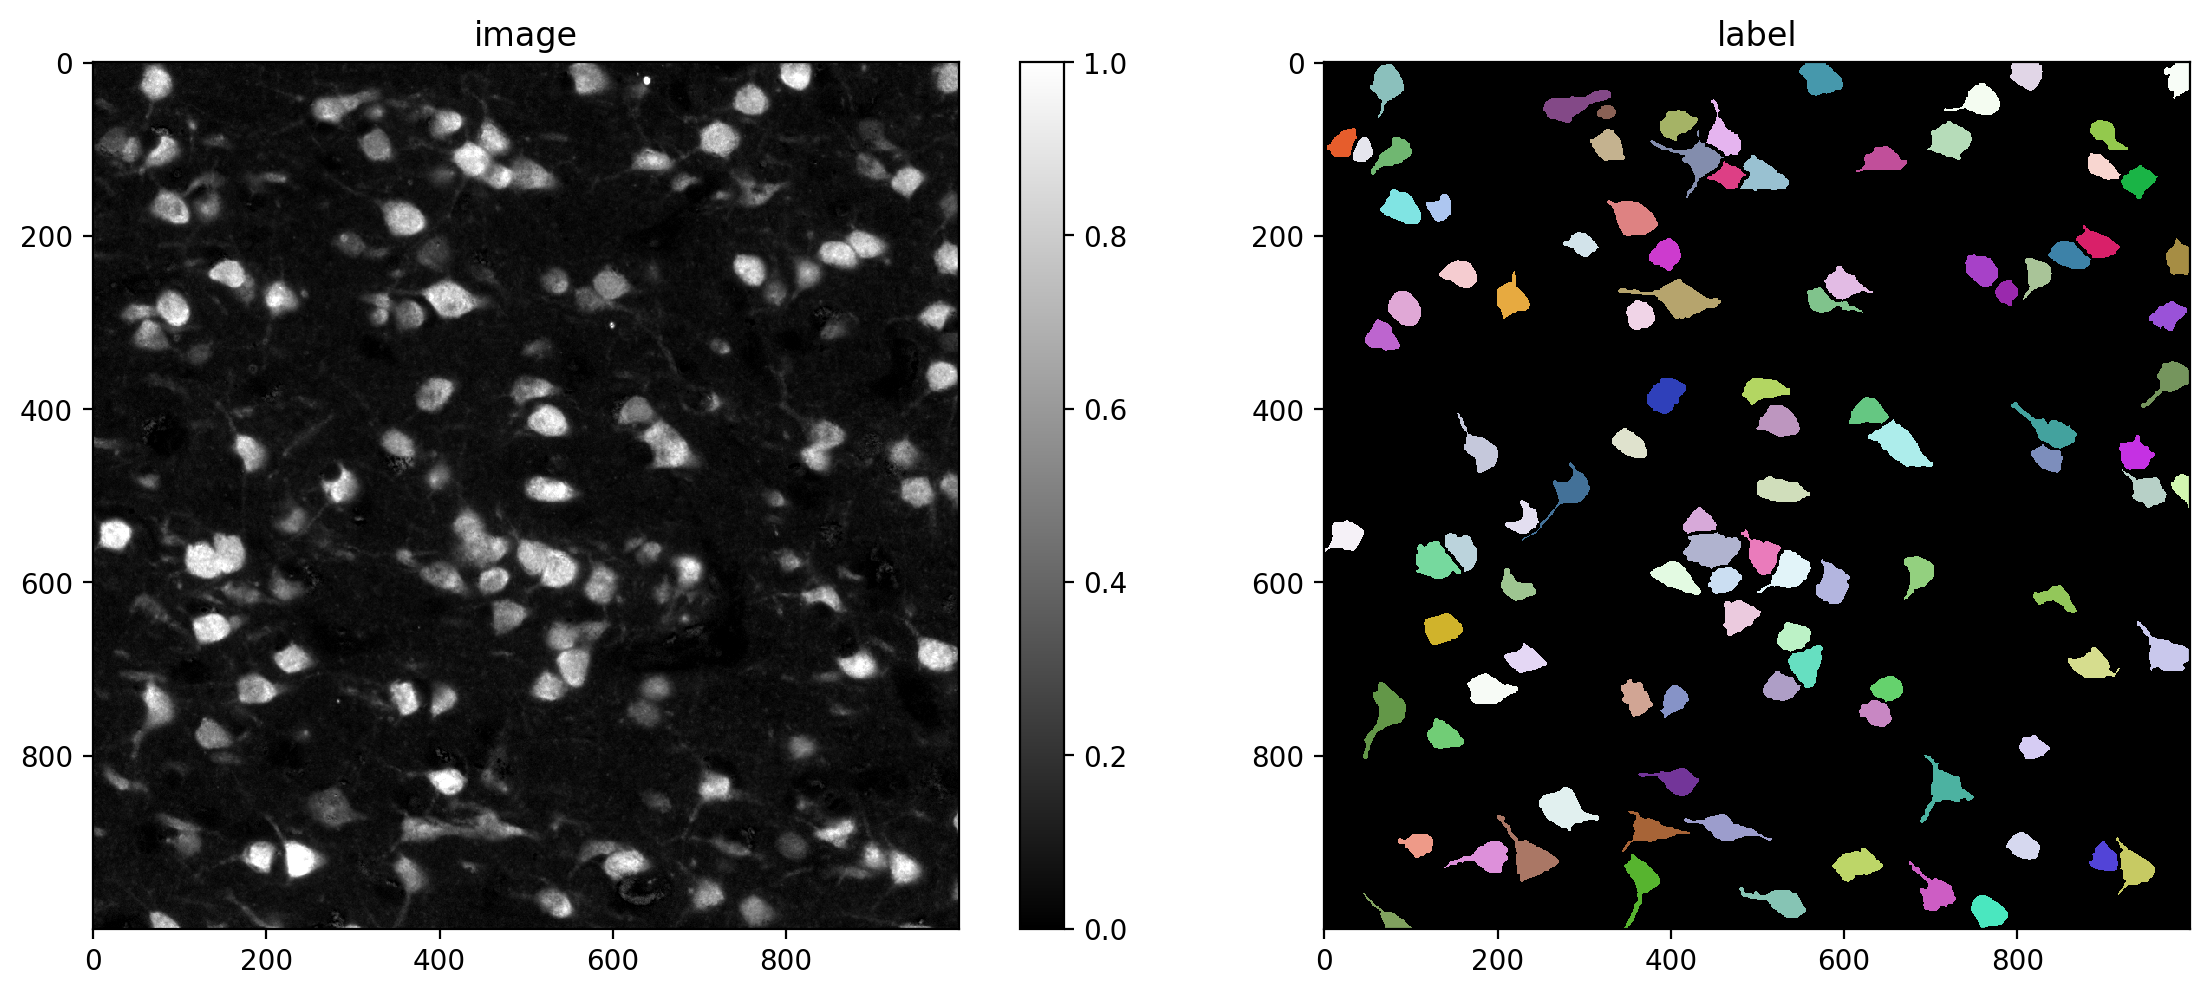

In [22]:
i = min(0, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
img.shape, lbl.shape

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [23]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class prediction (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [24]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 16,
    unet_batch_norm = True,
    # train_epochs = 100,
    train_dist_loss = 'mse',
)
print(conf)
vars(conf)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mse', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=True, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='rel

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': True,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mse',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 

In [25]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)
use_gpu

2024-09-04 22:41:47.404906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-04 22:41:47.405415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-04 22:41:47.406645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-04 22:41:47.407692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-09-04 22:41:47.408262: W tensorflow/compiler/xl

True

ompiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-09-04 22:41:47.409383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2024-09-04 22:41:47.409749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-09-04 22:41:47.410145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2024-09-04 22:41:47.410529: W tensorflow/compiler/xla/stream_executor/platform/d

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [44]:
# model = StarDist2D.from_pretrained('2D_versatile_he')
# model = StarDist2D(conf, name='stardist', basedir='models')
# model.load_weights('/home/mac/wday/.keras/models/StarDist2D/2D_versatile_fluo/weights_best.h5')
model = StarDist2D.from_pretrained('2D_versatile_fluo')
model.config.train_epochs = 100

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [45]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [54. 46.]
network field of view :  [94 94]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [46]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

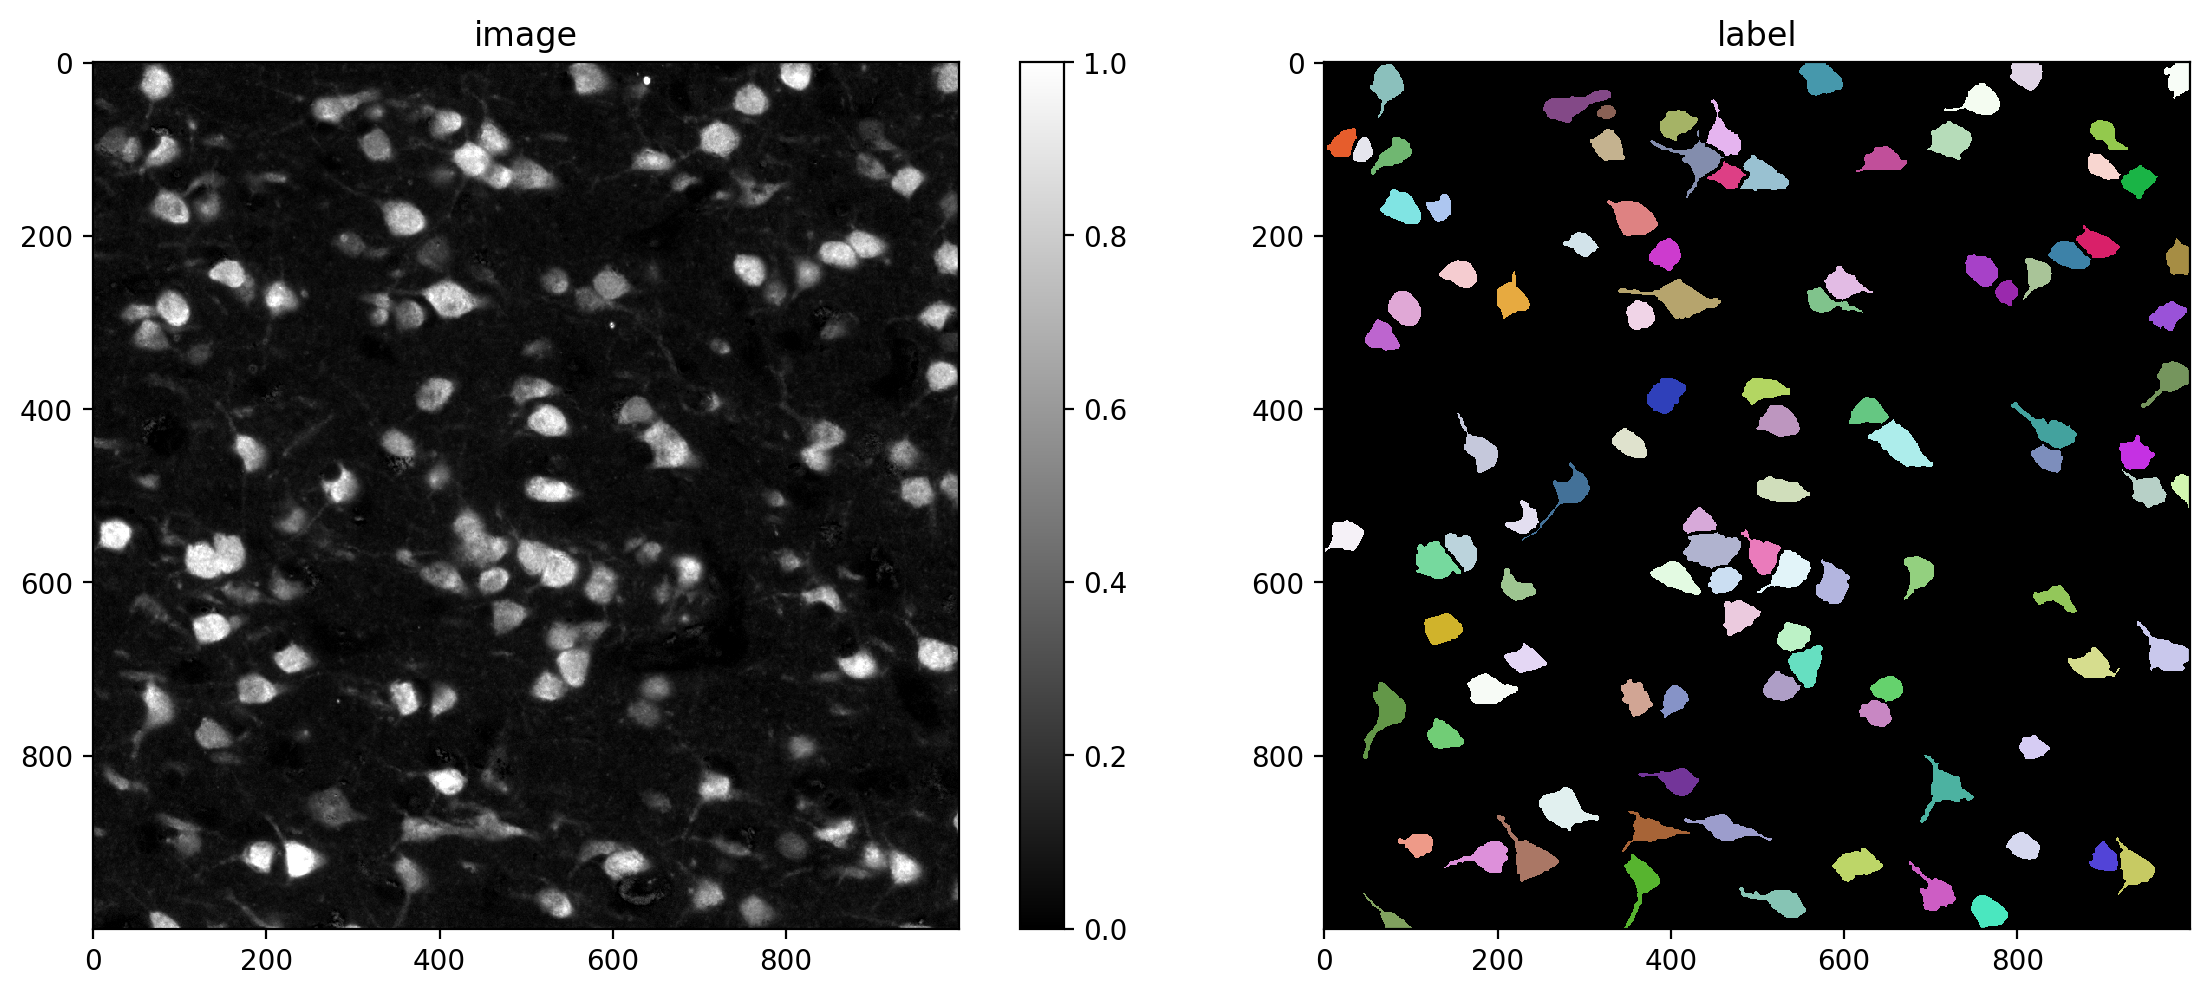

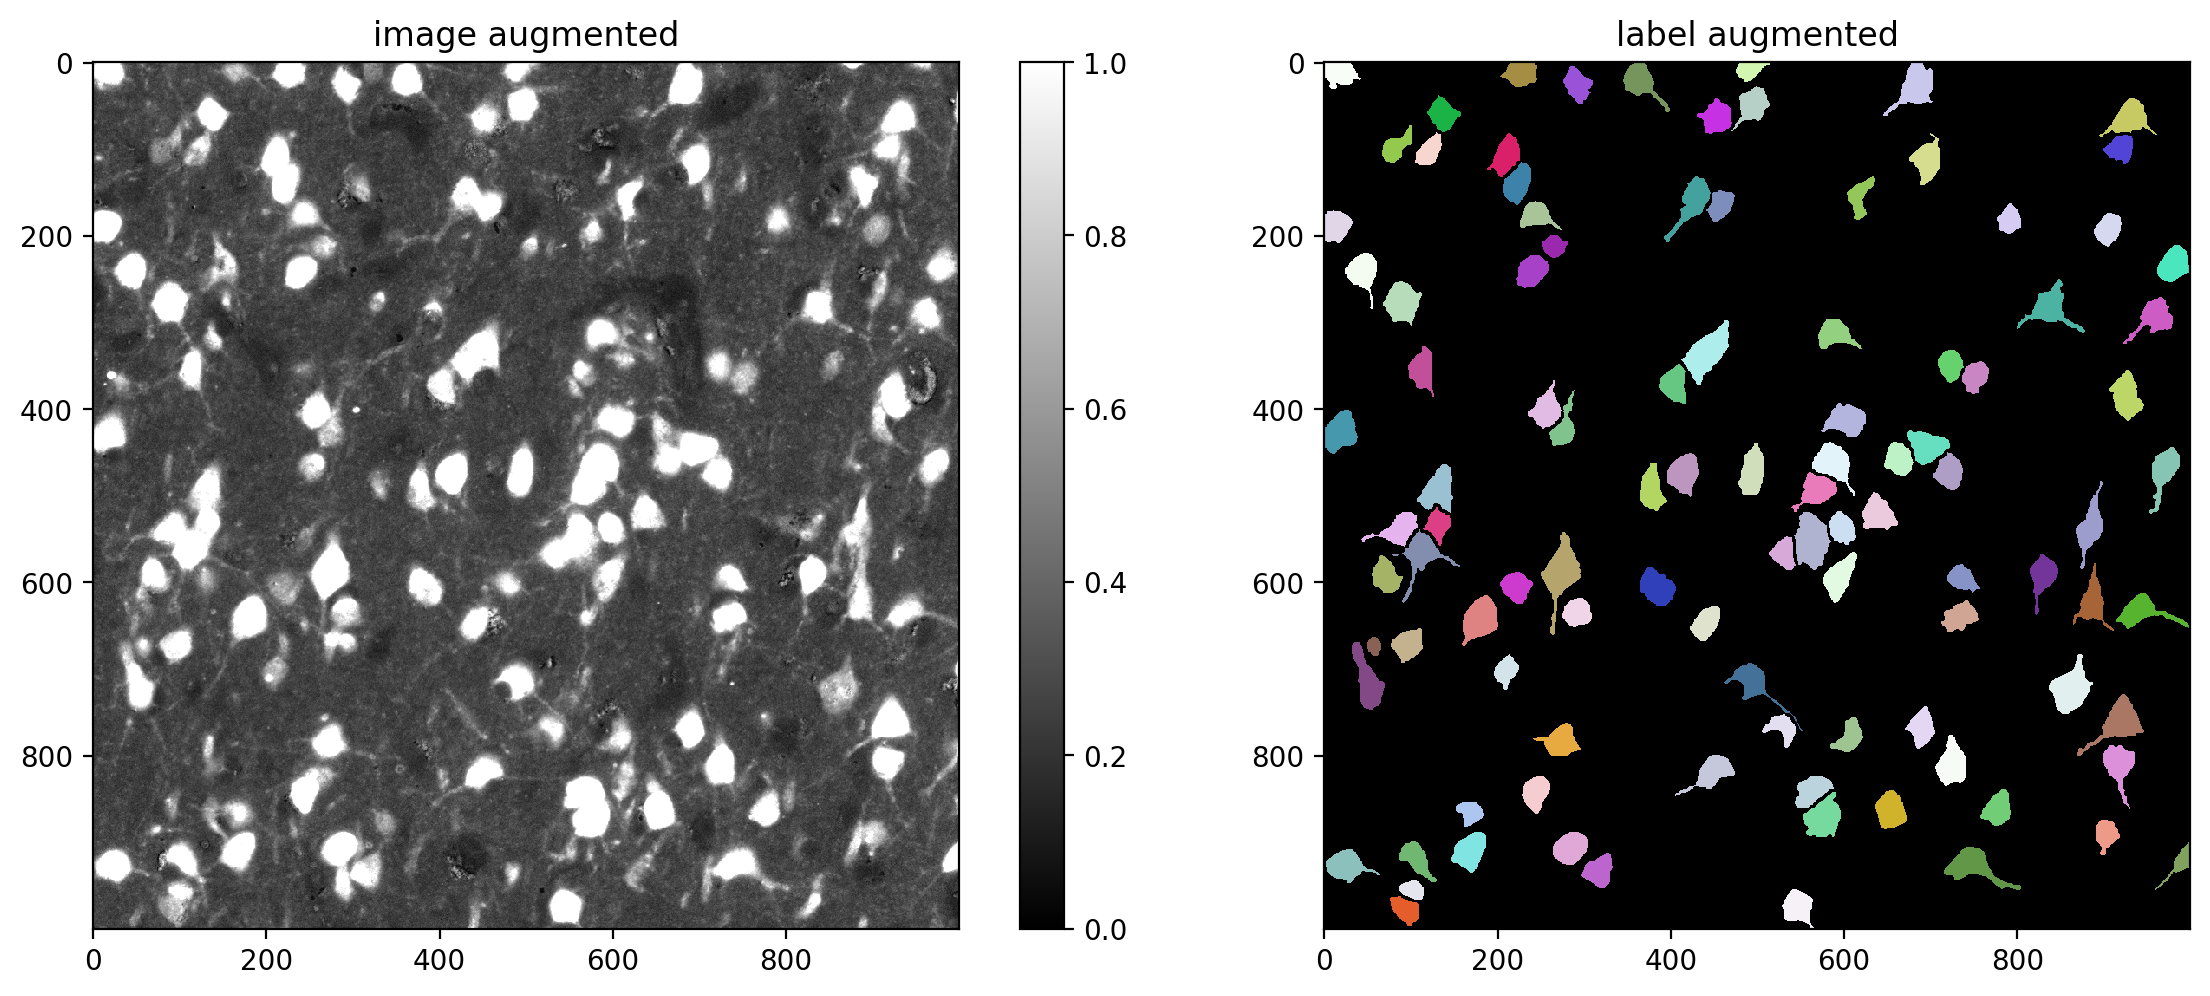

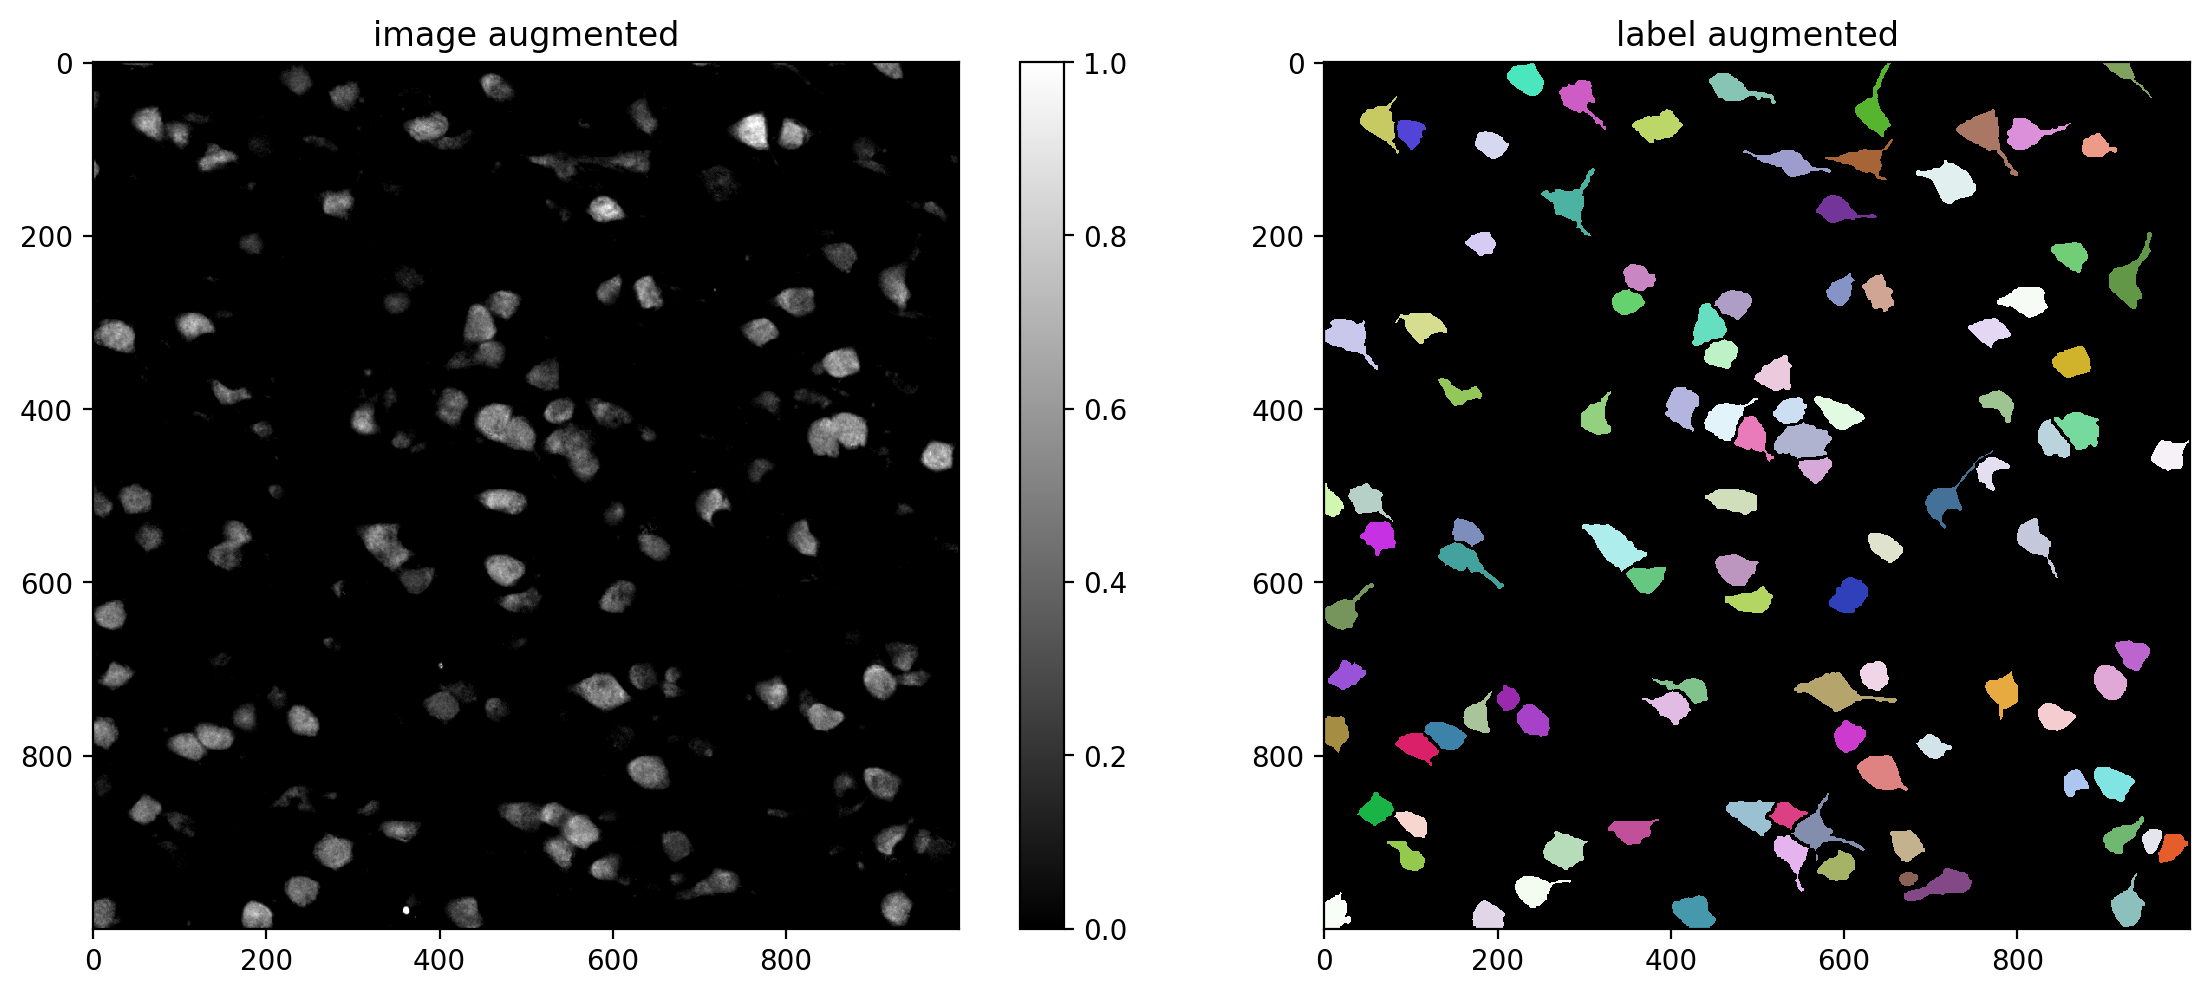

In [47]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(2):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [48]:
X_trn[0].shape, Y_trn[0].shape

((1000, 1000), (1000, 1000))

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [49]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

Epoch 1/100
400/400 [==============================] - 463s 1s/step - loss: 0.6938 - prob_loss: 0.0920 - dist_loss: 3.0090 - prob_kld: 0.0265 - dist_relevant_mae: 3.0084 - dist_relevant_mse: 34.1974 - dist_dist_iou_metric: 0.7203 - val_loss: 0.4140 - val_prob_loss: 0.0268 - val_dist_loss: 1.9363 - val_prob_kld: 0.0086 - val_dist_relevant_mae: 1.9357 - val_dist_relevant_mse: 7.6833 - val_dist_dist_iou_metric: 0.8076 - lr: 3.0000e-04
Epoch 2/100
400/400 [==============================] - 455s 1s/step - loss: 0.6364 - prob_loss: 0.0893 - dist_loss: 2.7353 - prob_kld: 0.0236 - dist_relevant_mae: 2.7347 - dist_relevant_mse: 27.3816 - dist_dist_iou_metric: 0.7404 - val_loss: 0.4254 - val_prob_loss: 0.0246 - val_dist_loss: 2.0040 - val_prob_kld: 0.0064 - val_dist_relevant_mae: 2.0034 - val_dist_relevant_mse: 8.1983 - val_dist_dist_iou_metric: 0.8065 - lr: 3.0000e-04
Epoch 3/100
400/400 [==============================] - 454s 1s/step - loss: 0.6142 - prob_loss: 0.0891 - dist_loss: 2.6258 - pro

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [50]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:03<00:01,  4.41it/s, 0.652 -> 0.647]


Using optimized values: prob_thresh=0.649201, nms_thresh=0.3.


{'prob': 0.6492005086205983, 'nms': 0.3}

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [52]:
# help(matching)

First predict the labels for all validation images:

In [53]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


Plot a GT/prediction example 

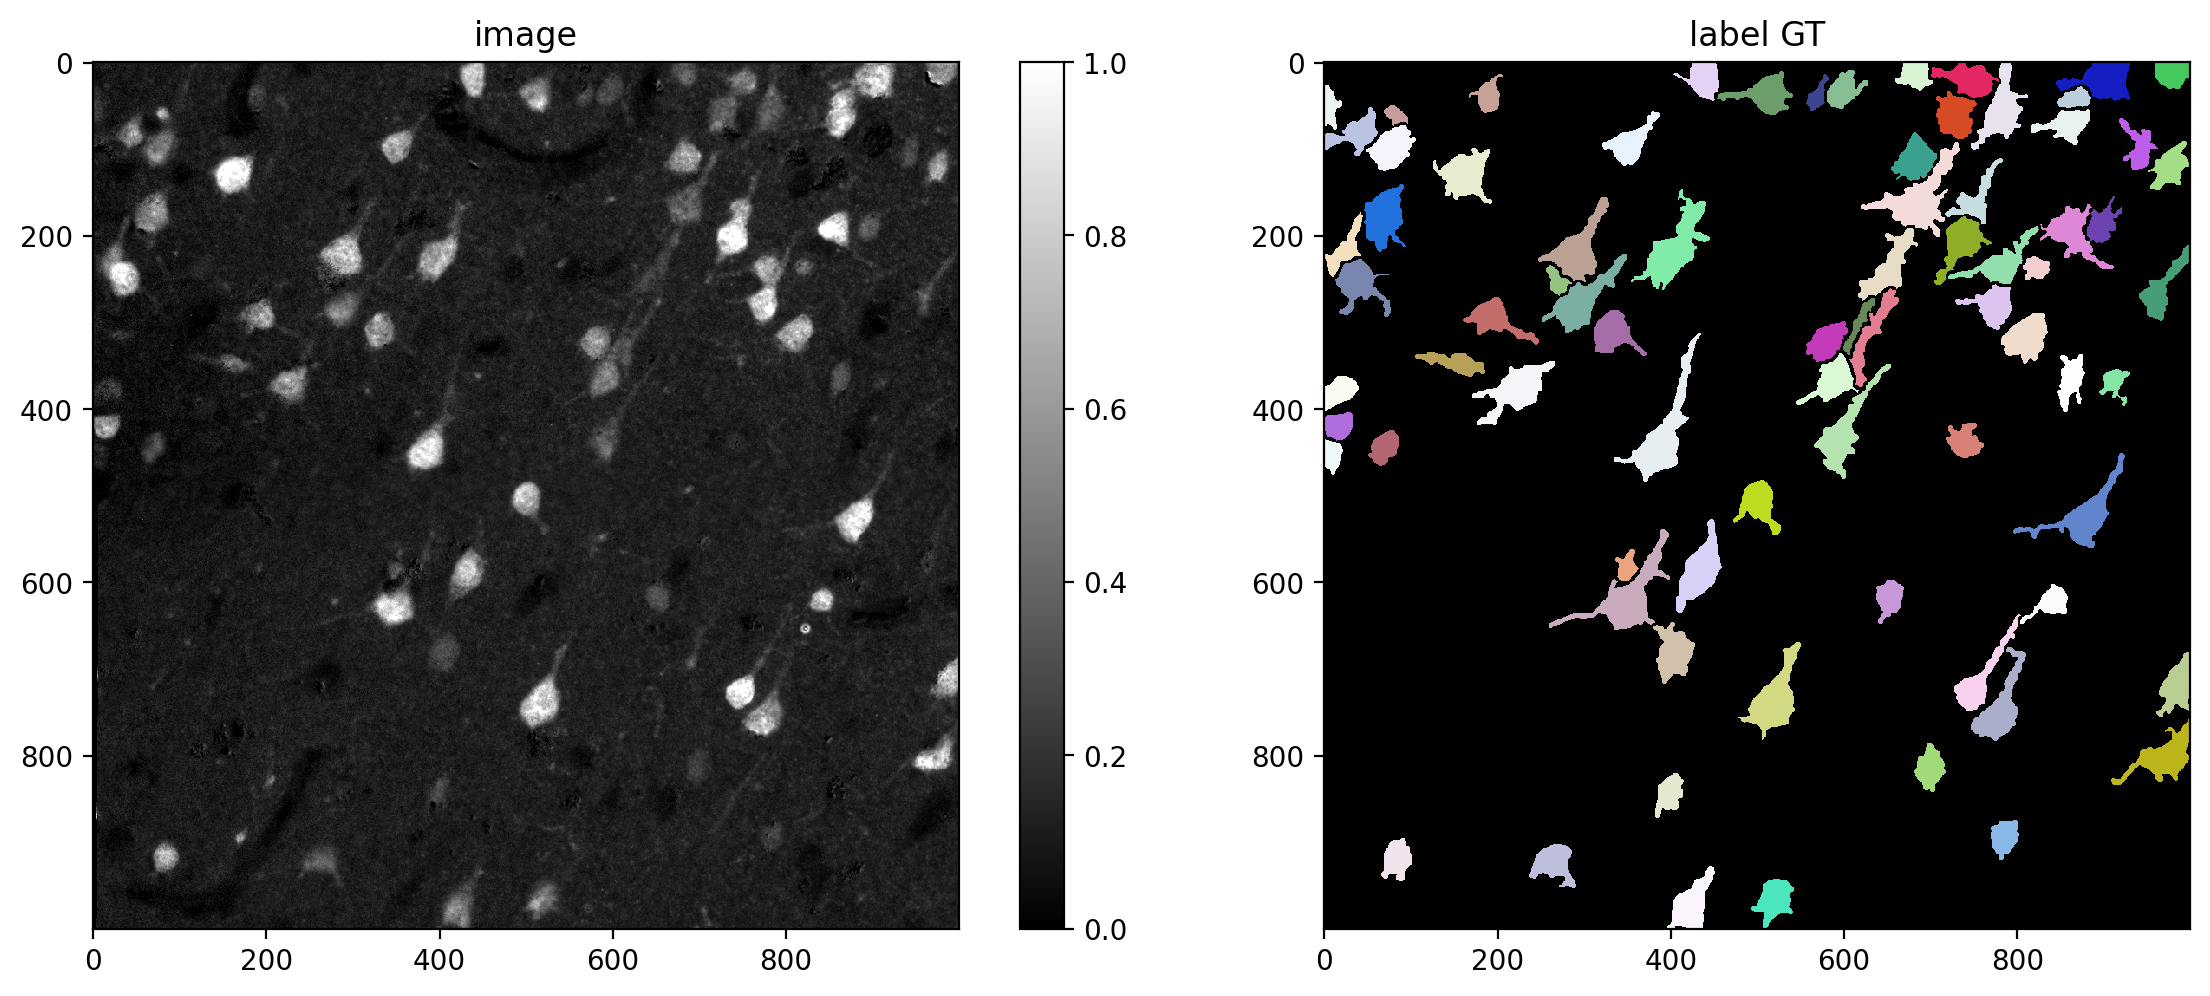

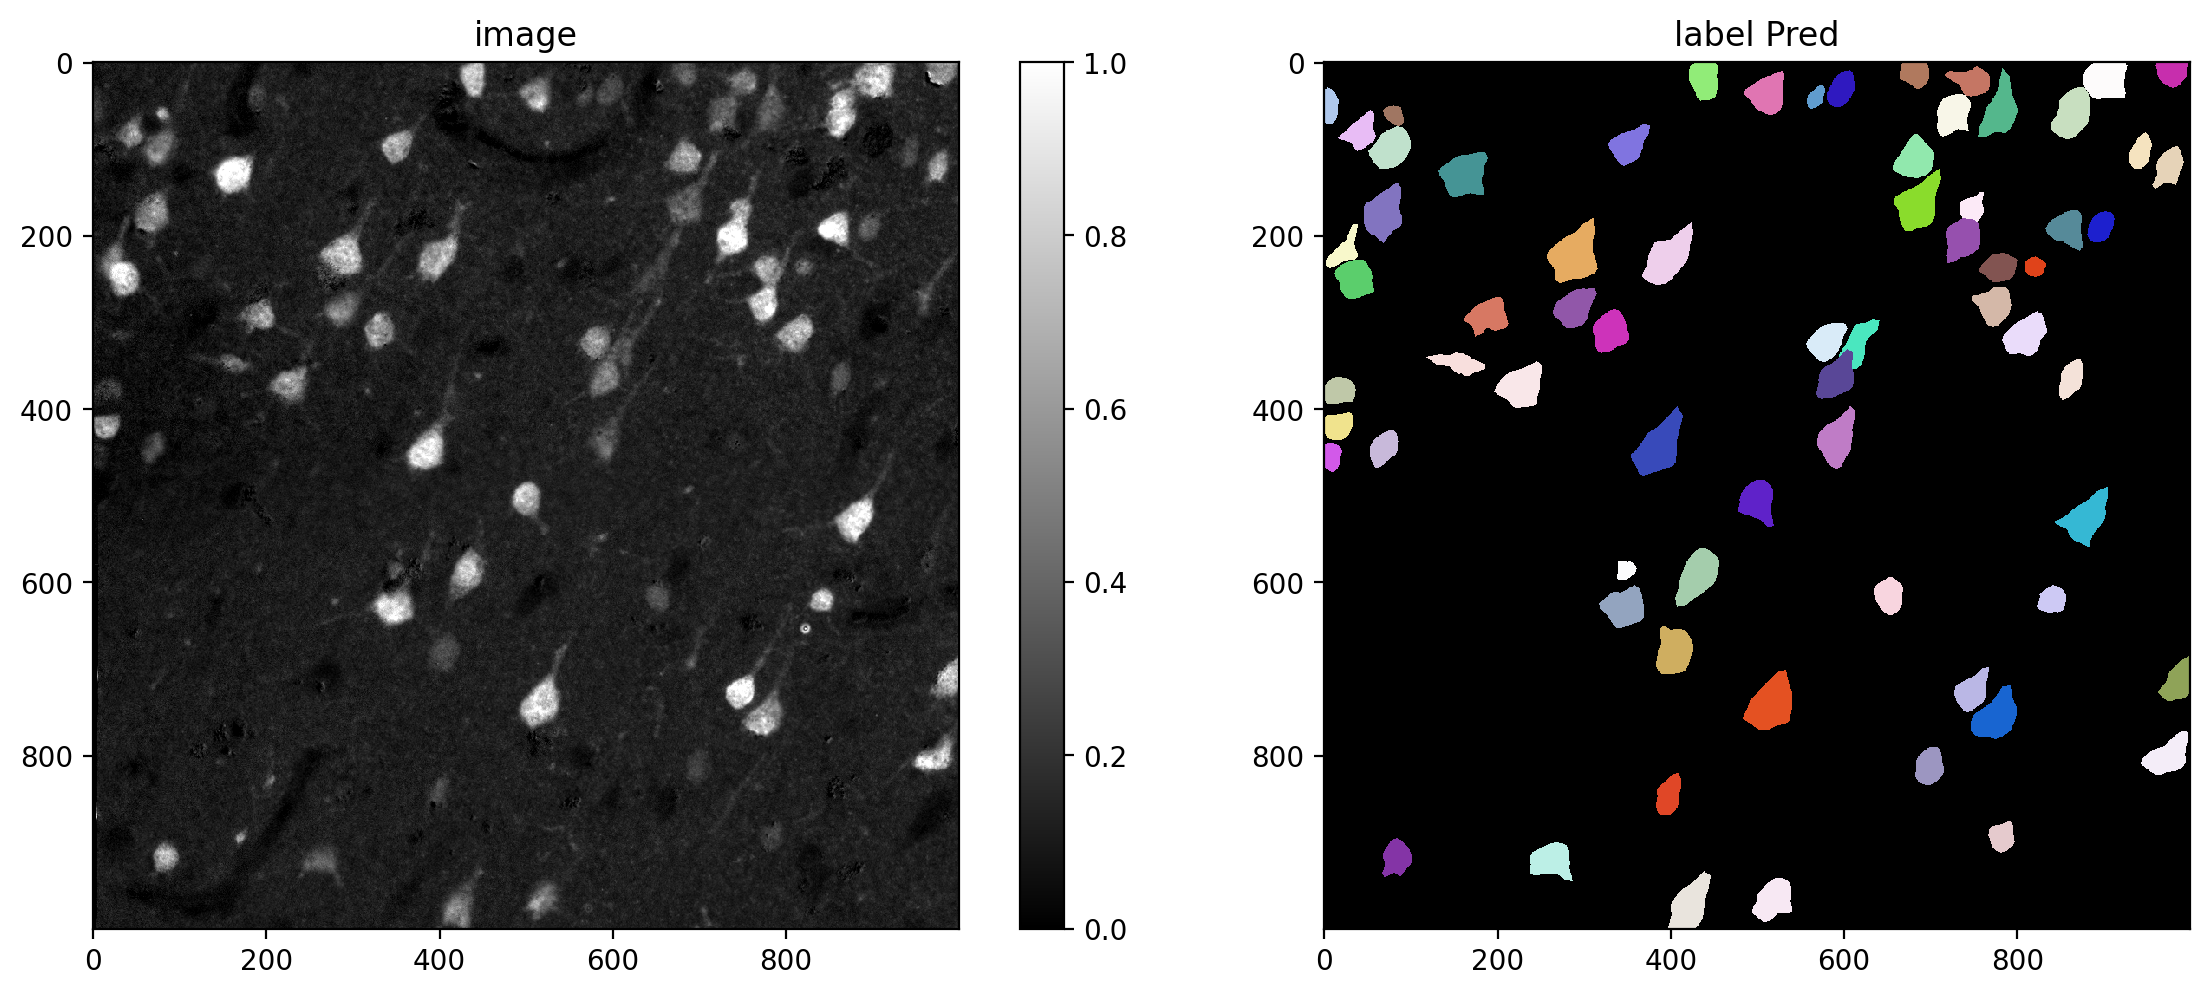

In [55]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [57]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00,  9.50it/s]


Example: Print all available matching statistics for $\tau=0.5$

In [58]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=10, tp=93, fn=24, precision=0.9029126213592233, recall=0.7948717948717948, accuracy=0.7322834645669292, f1=0.8454545454545455, n_true=117, n_pred=103, mean_true_score=0.585429933336046, mean_matched_score=0.7365086258098643, panoptic_quality=0.6226845654574308, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

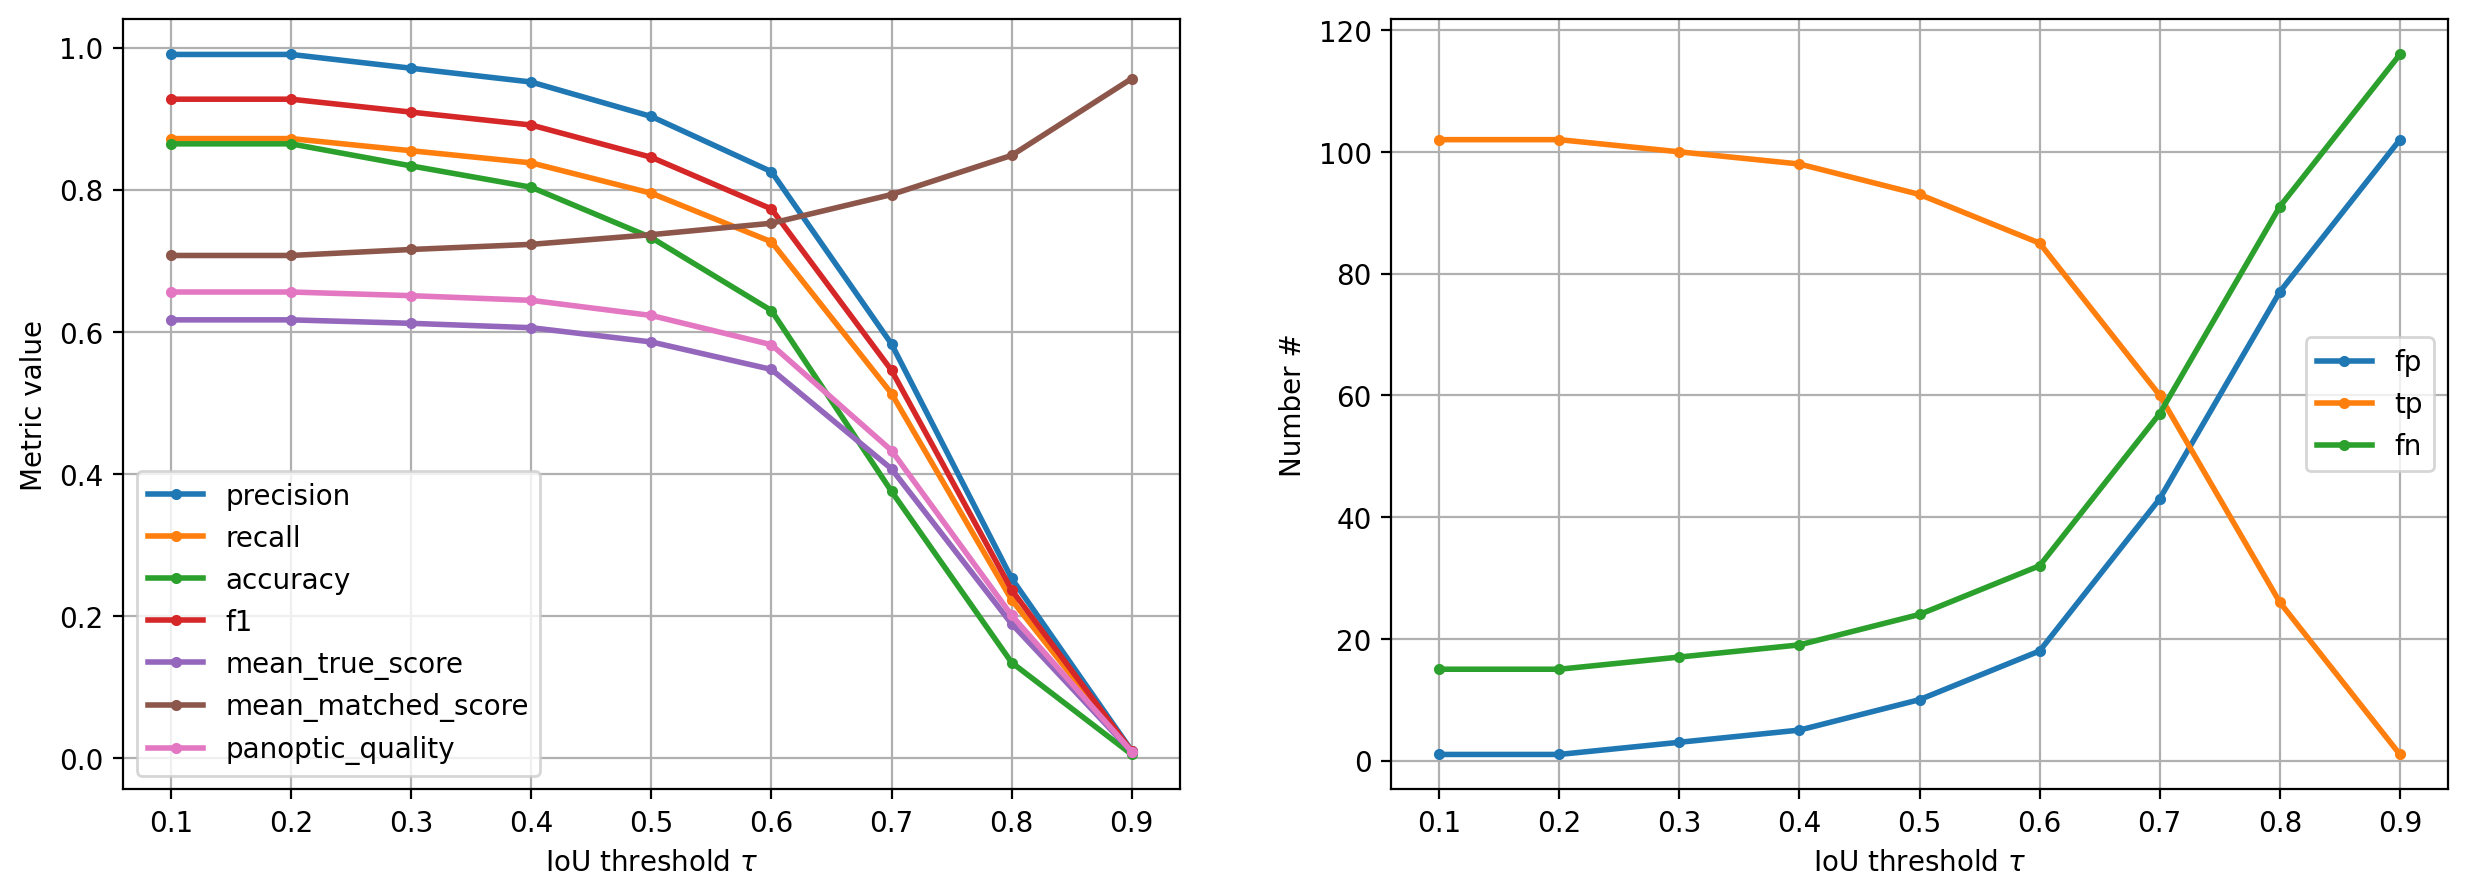

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

In [62]:
stats[taus.index(0.1)]

DatasetMatching(criterion='iou', thresh=0.1, fp=1, tp=102, fn=15, precision=0.9902912621359223, recall=0.8717948717948718, accuracy=0.864406779661017, f1=0.9272727272727272, n_true=117, n_pred=103, mean_true_score=0.61653686588646, mean_matched_score=0.7072040520462335, panoptic_quality=0.6557710300792348, by_image=False)

In [63]:
X_test = sorted(glob(IMG_PATH + '/val/raw/*.tif'))
Y_test = sorted(glob(IMG_PATH + '/val/masks/*.tif'))

In [64]:
X_test = list(map(imread,X_test))
Y_test = list(map(imread,Y_test))

In [65]:
# X_test = [ np.take(x, [1, 2], axis=0) for x  in X_test]
# X_test = [ np.transpose(x, (1, 2, 0)) for x  in X_test]
X_test = [ x[1] for x  in X_test]
n_channel = 1 if X_test[0].ndim == 2 else X_test[0].shape[-1]
X_test[0].shape

(600, 600)

In [66]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X_test = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_test)]
Y_test = [fill_label_holes(y) for y in tqdm(Y_test)]

100%|██████████| 23/23 [00:00<00:00, 158.28it/s]


In [67]:
Y_test_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_test)]

100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


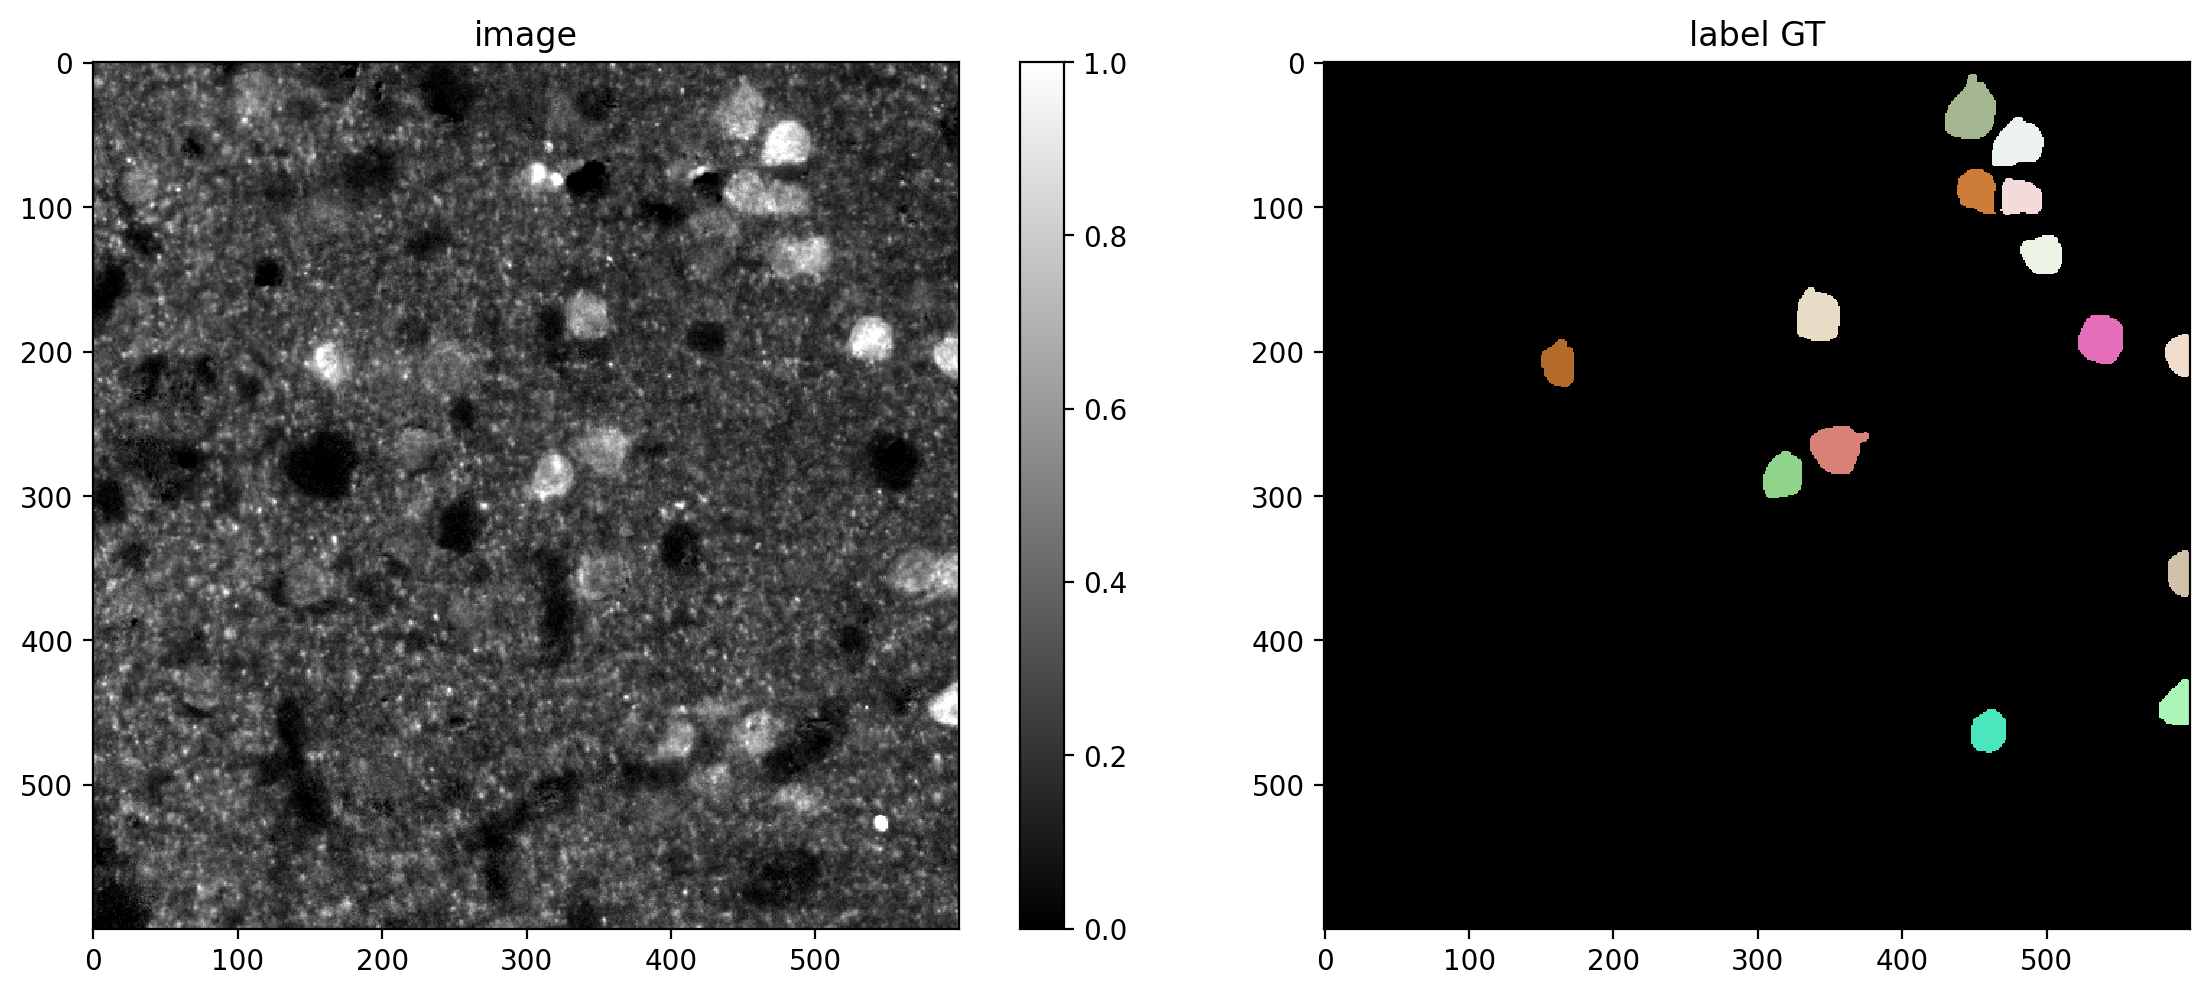

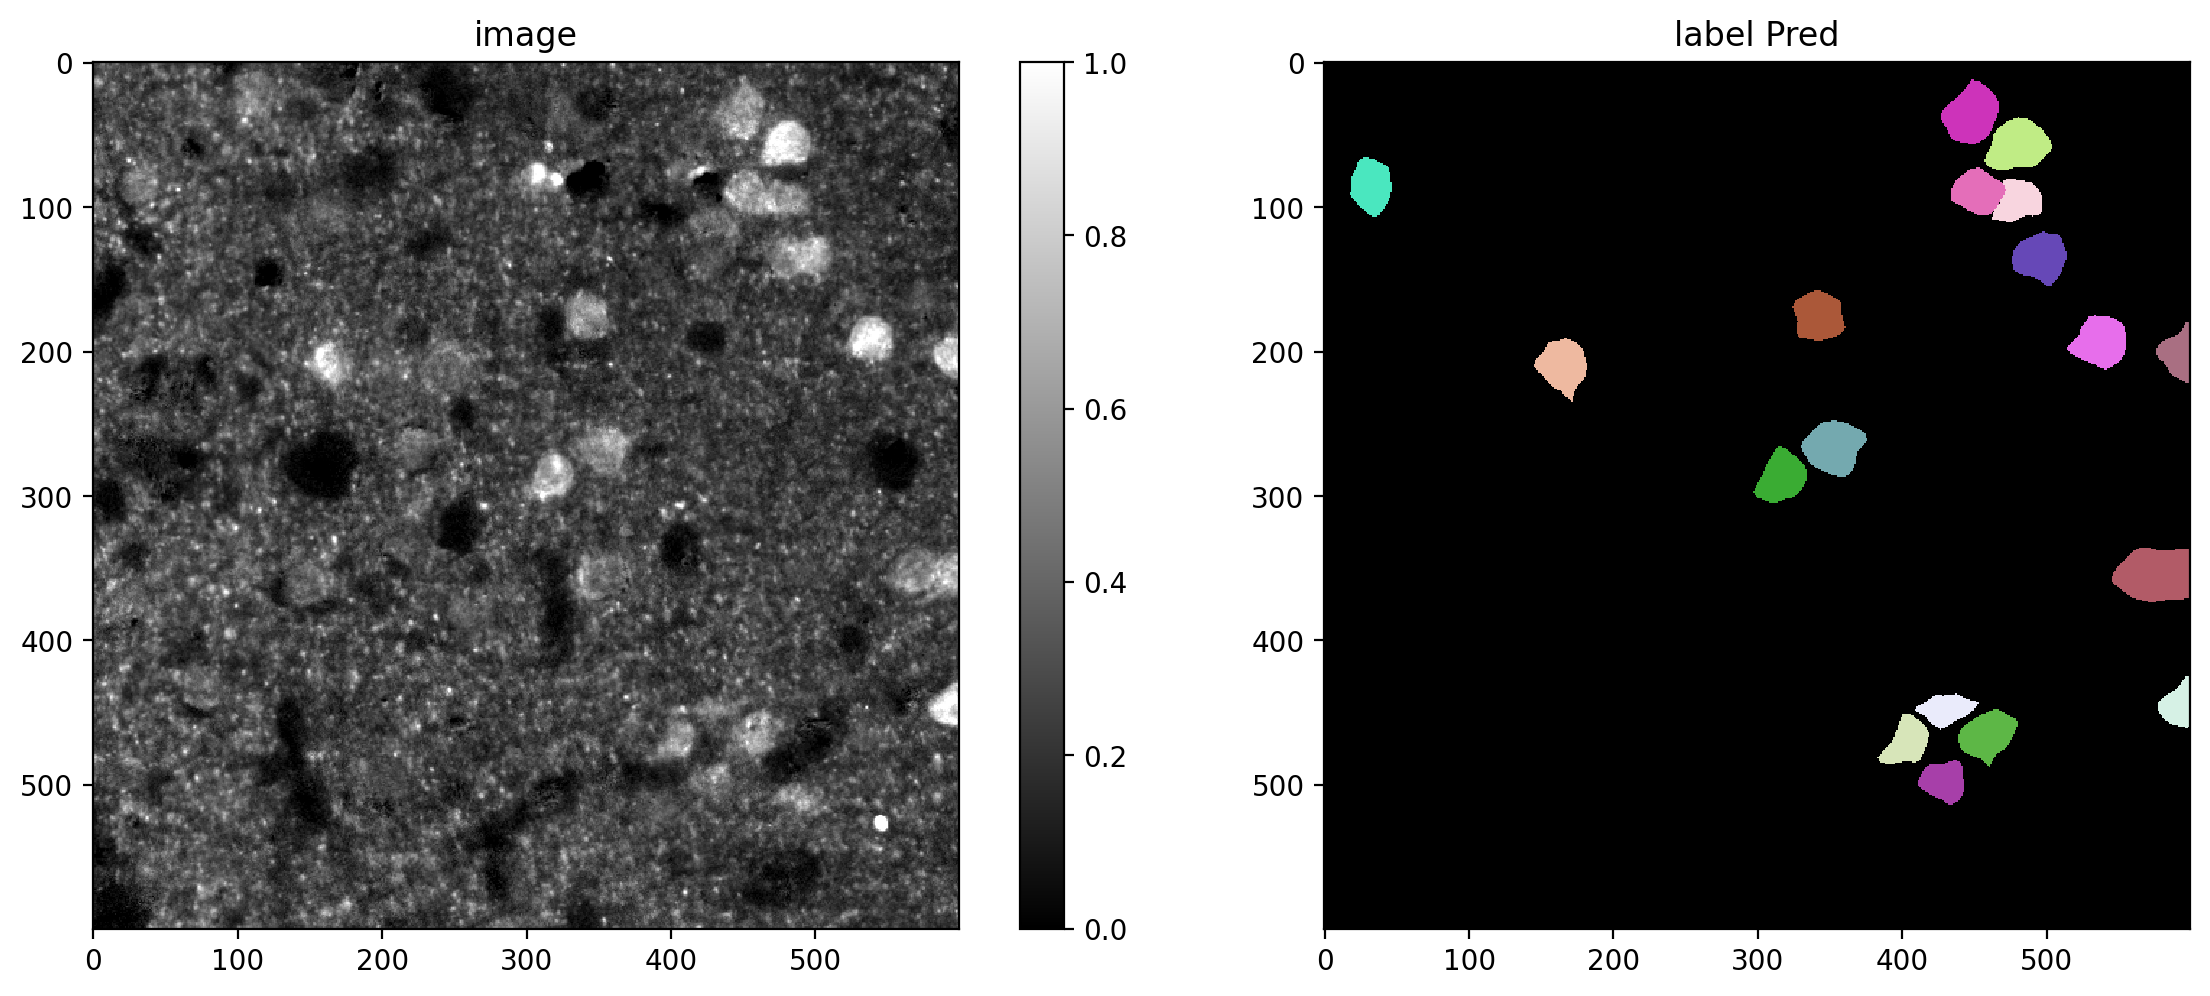

In [68]:
plot_img_label(X_test[9],Y_test[9], lbl_title="label GT")
plot_img_label(X_test[9],Y_test_pred[9], lbl_title="label Pred")

In [69]:
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


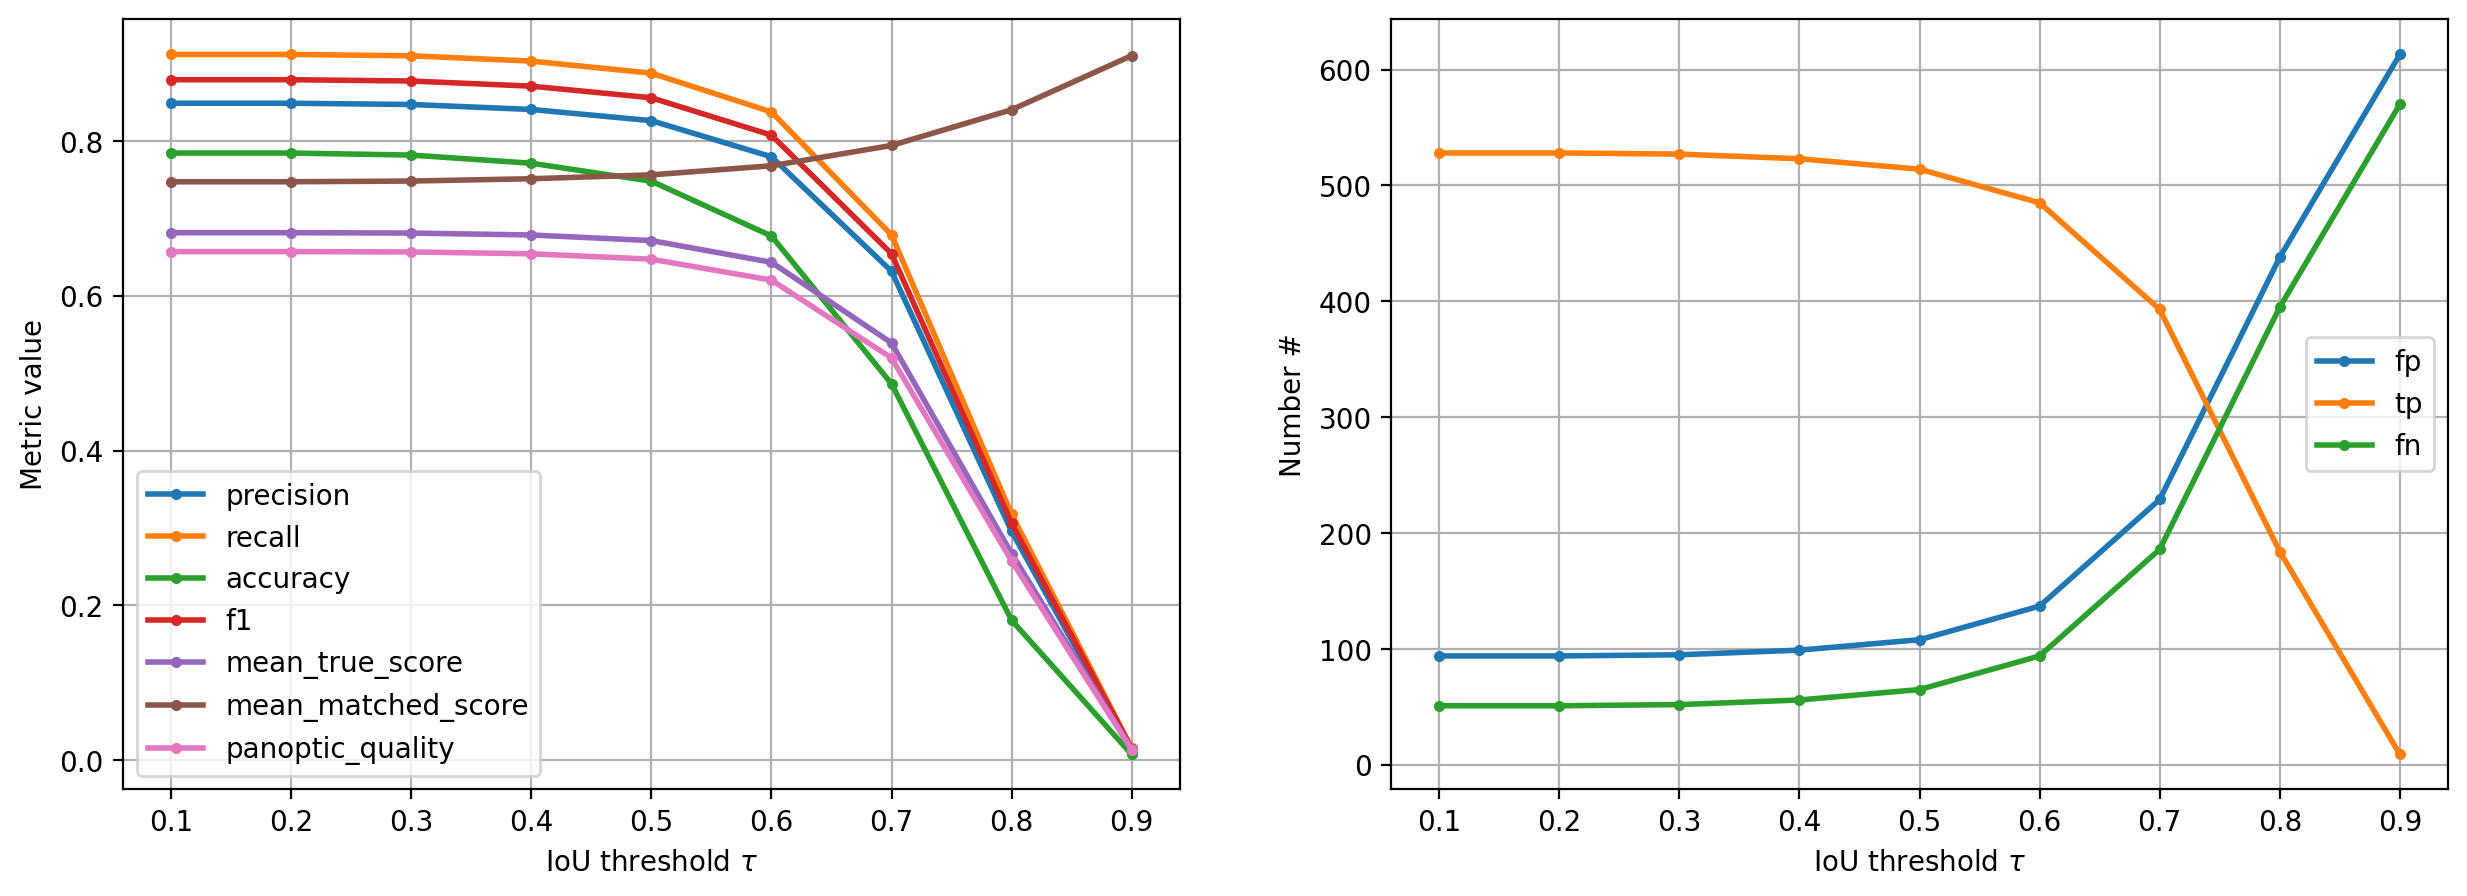

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

In [80]:
stats[taus.index(0.2)]

DatasetMatching(criterion='iou', thresh=0.2, fp=94, tp=528, fn=51, precision=0.8488745980707395, recall=0.9119170984455959, accuracy=0.7845468053491828, f1=0.8792672772689425, n_true=579, n_pred=622, mean_true_score=0.6816022943750358, mean_matched_score=0.74743887962717, panoptic_quality=0.6571985486147306, by_image=False)

In [81]:
filenames = sorted(glob(IMG_PATH + '/val/masks/*.tif'))

In [82]:
import csv

f1_scores = []
dices = []
with open('metrics.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Filename', 'F1-score', 'Dice-Coef', 'TP', 'FP', 'FN'])

    for idx, imagepath in enumerate(filenames):
        pred = Y_test_pred[idx]
        truth = Y_test[idx]
        dice = np.zeros((int(pred.max()), int(truth.max())))
        for i in range(dice.shape[0]):
            for j in range(dice.shape[1]):
                dice[i][j] = (2 * np.sum(np.logical_and(pred == i+1, truth == j+1))) / (np.sum(pred == i+1) + np.sum(truth == j+1))
        tp = np.sum(dice.max(axis=1) >= 0.5)
        fp = dice.shape[0] - tp
        fn = dice.shape[1] - tp
        f1 = tp / (tp + (fp + fn) / 2)
        f1_scores.append(f1)
        dice_coef = dice.max(axis=1)[dice.max(axis=1) >= 0.5]
        dices.append(dice_coef)

        writer.writerow([imagepath.split('/')[-1], f1, dice_coef.mean(), tp, fp, fn])

In [83]:
from tifffile import imwrite

for idx, filename in enumerate(filenames):
    imwrite('outputs/' + filename.split('/')[-1].split('\\')[-1], Y_test_pred[idx])